In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import folium
from folium import plugins
import branca.colormap as cm
import requests
from IPython.display import display, HTML, Markdown
from datetime import time
from scipy.stats import probplot

In [3]:
# pandas
# read data
data = pd.read_csv("../data/NYPD_Complaint_Data_Historic.csv")
data.head()

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,...,SUSP_SEX,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX
0,298690695,12/30/2024,08:55:00,12/30/2024,09:30:00,18,12/31/2024,109,GRAND LARCENY,443,...,M,NaN,40.764668,-73.976952,"(40.764668, -73.976952)",PATROL BORO MAN SOUTH,(null),25-44,WHITE HISPANIC,M
1,298704236,12/30/2024,07:30:00,12/31/2024,19:32:00,44,12/31/2024,341,PETIT LARCENY,343,...,(null),NaN,40.830365,-73.927420,"(40.830365, -73.92742)",PATROL BORO BRONX,(null),18-24,BLACK,M
2,298704228,12/30/2024,15:00:00,12/30/2024,15:50:00,42,12/31/2024,109,GRAND LARCENY,443,...,U,NaN,40.835649,-73.885610,"(40.835649, -73.88561)",PATROL BORO BRONX,(null),25-44,BLACK,M
3,298695201,12/31/2024,21:00:00,12/31/2024,21:30:00,78,12/31/2024,109,GRAND LARCENY,443,...,M,NaN,40.680578,-73.974919,"(40.680578, -73.974919)",PATROL BORO BKLYN SOUTH,(null),25-44,ASIAN / PACIFIC ISLANDER,M
4,298702375,12/31/2024,03:00:00,12/31/2024,06:00:00,42,12/31/2024,109,GRAND LARCENY,443,...,U,NaN,40.822428,-73.908321,"(40.822428, -73.908321)",PATROL BORO BRONX,(null),25-44,BLACK,M


In [28]:
# check all disticnt categories
data['Category'].unique()

array(['ROBBERY', 'VEHICLE THEFT', 'ASSAULT', 'TRESPASS', 'BURGLARY',
       'LARCENY/THEFT', 'DRUG/NARCOTIC', 'VANDALISM', 'WEAPON LAWS',
       'PROSTITUTION', 'DRUNKENNESS', 'STOLEN PROPERTY'], dtype=object)

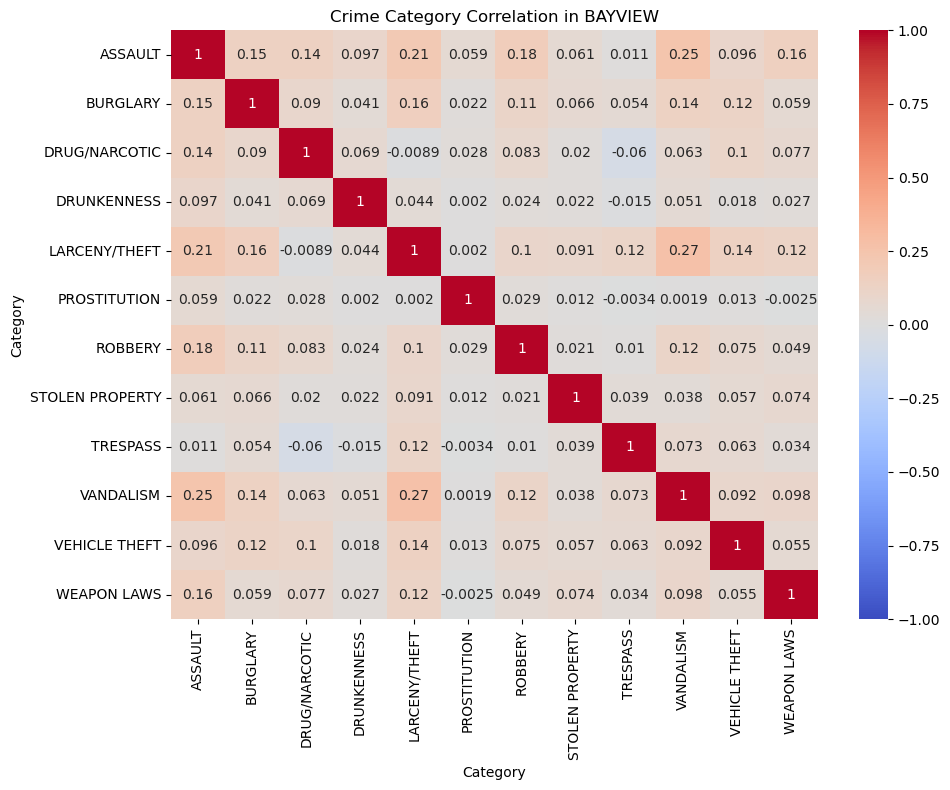

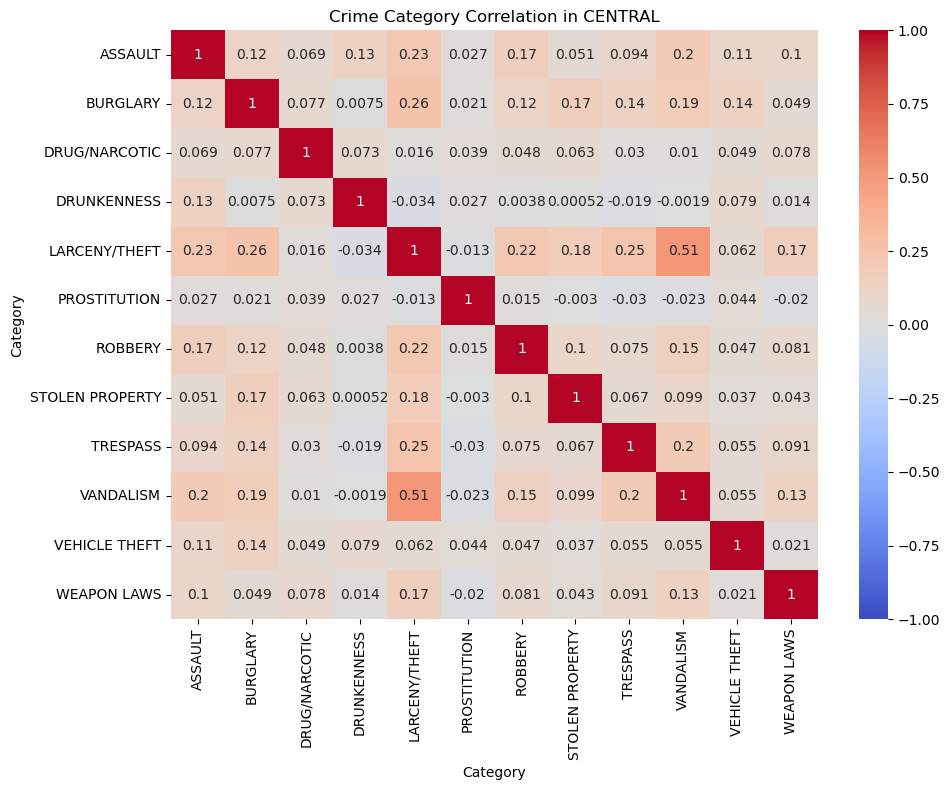

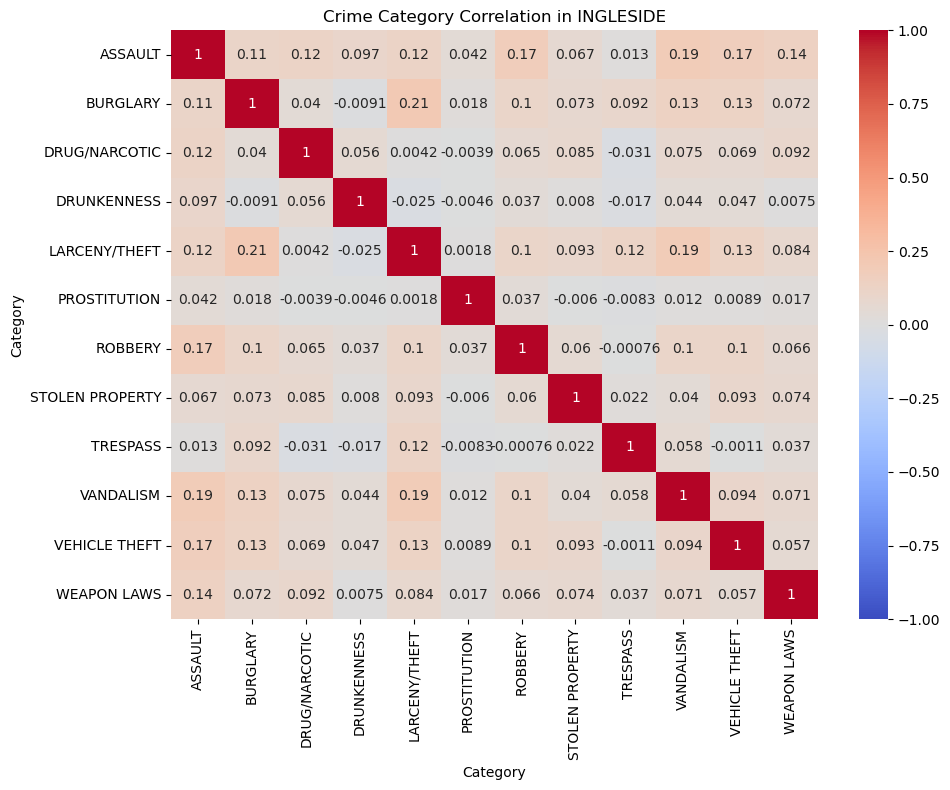

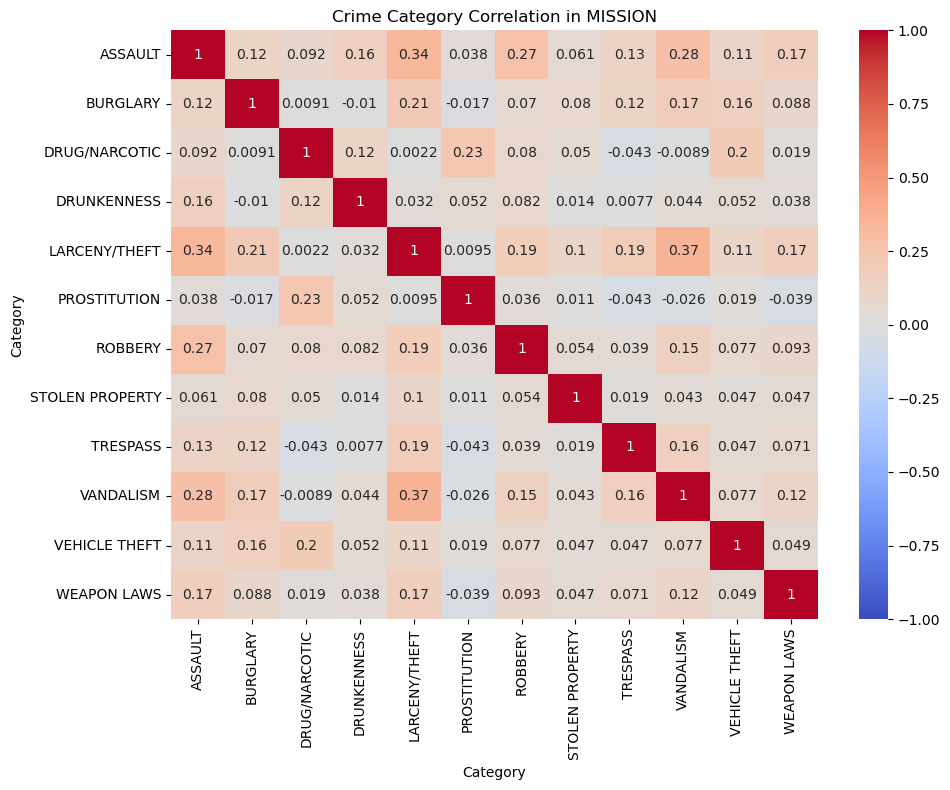

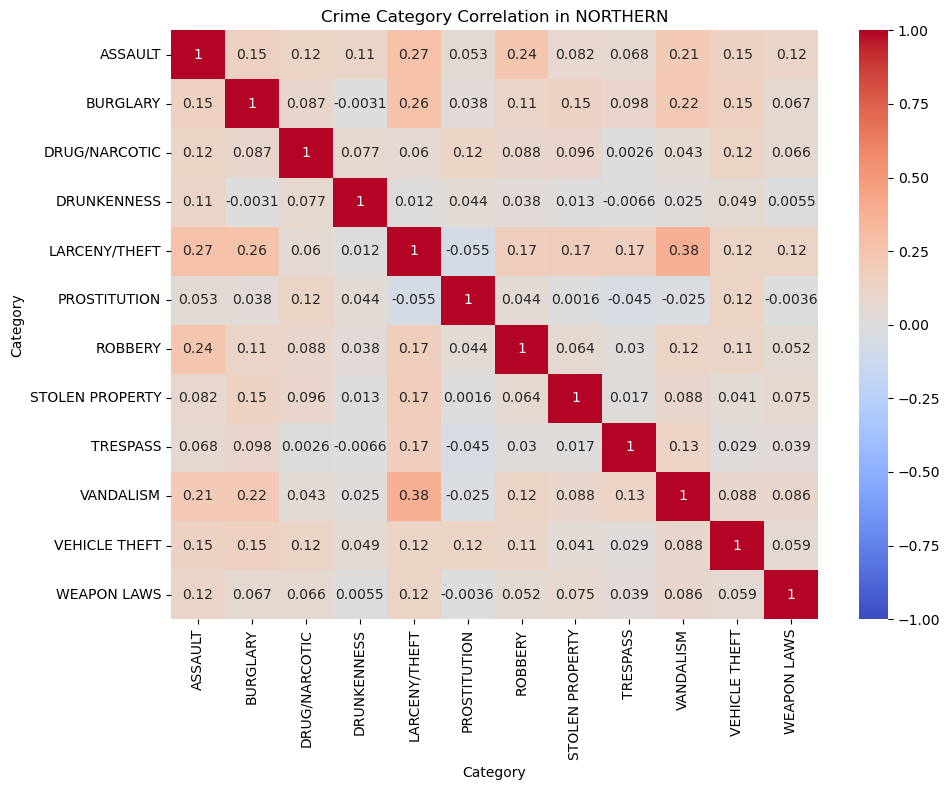

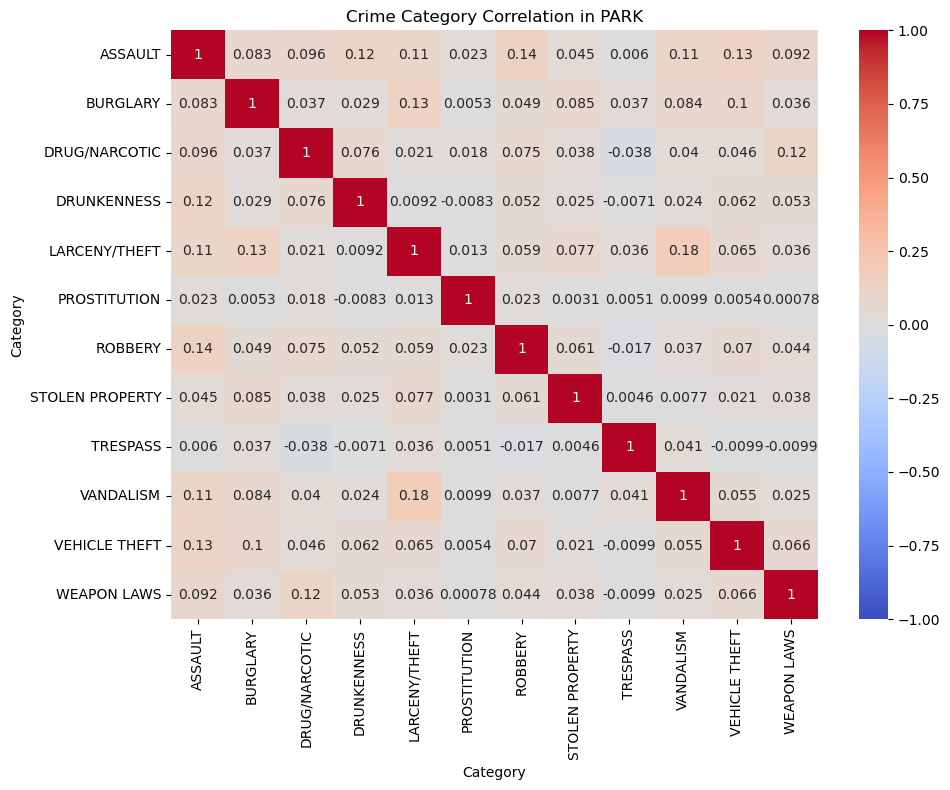

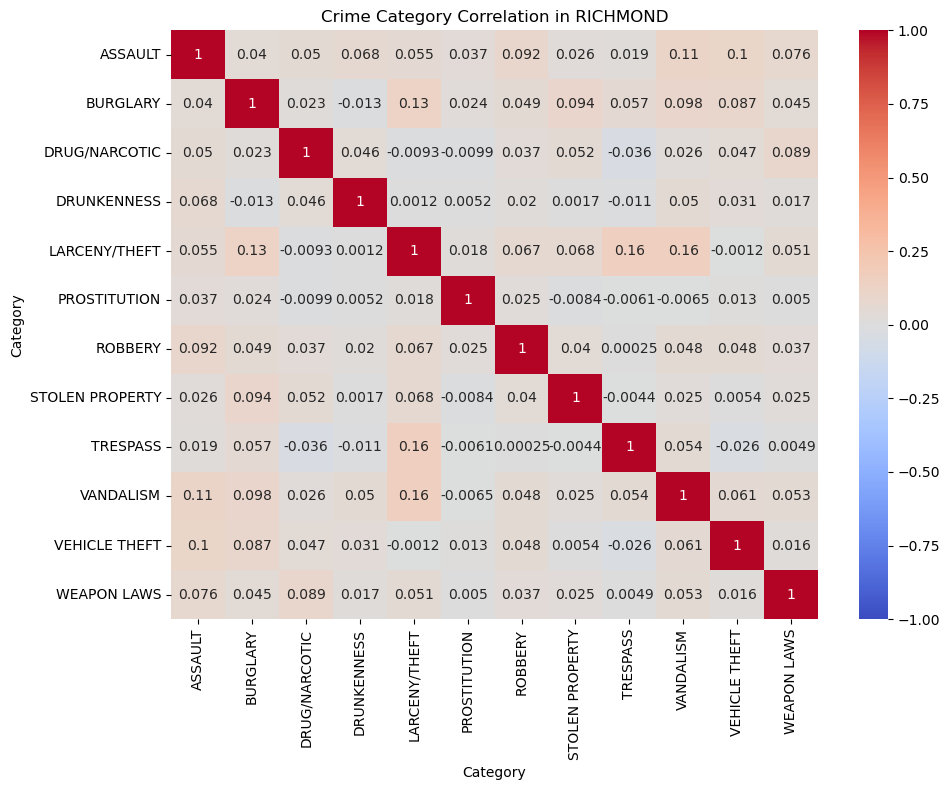

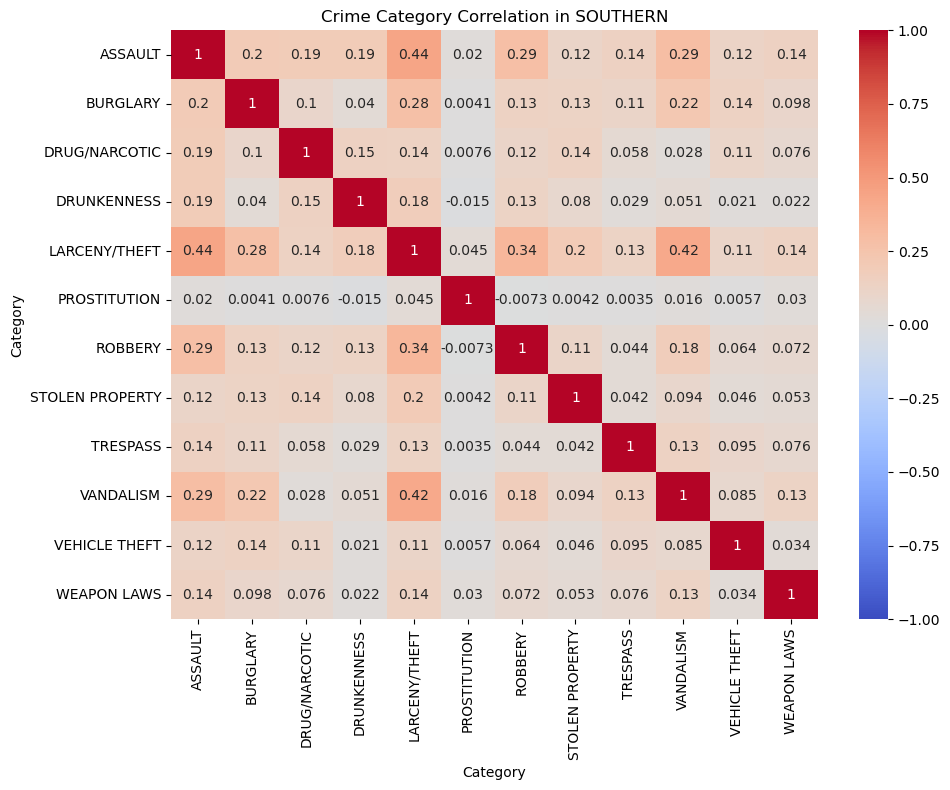

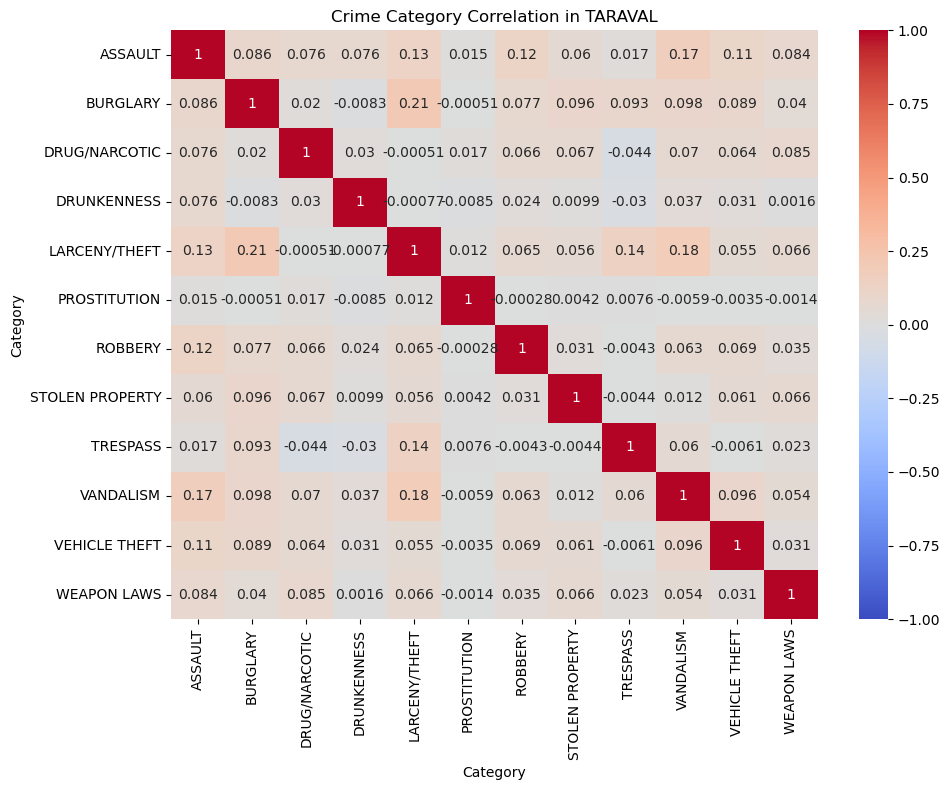

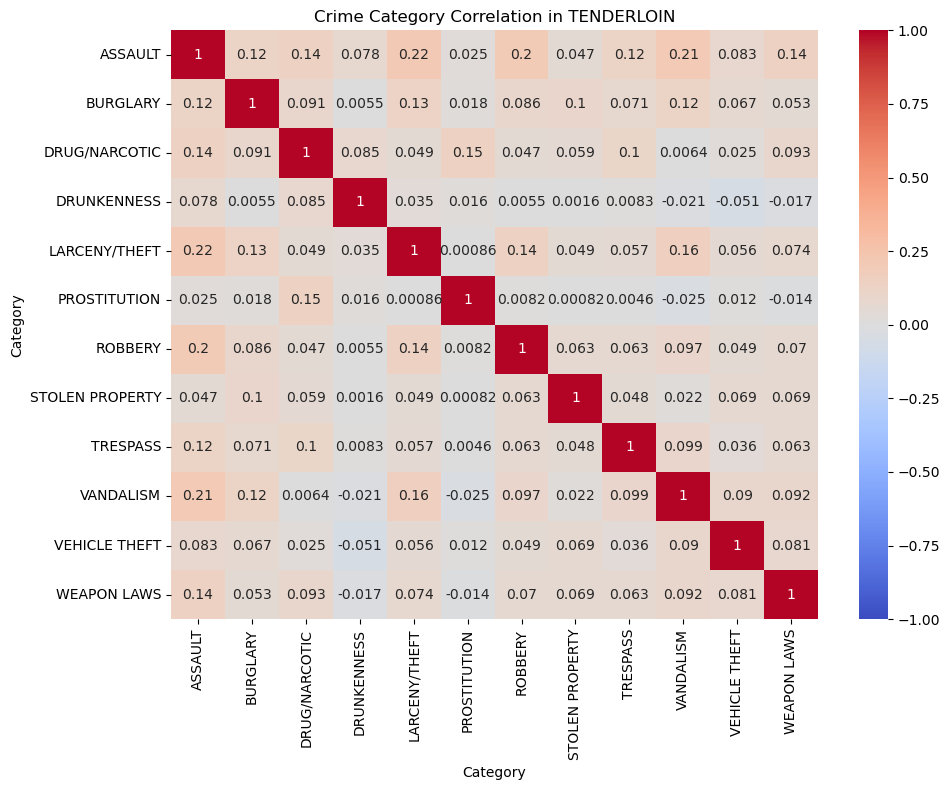

In [29]:
# Filter invalid coordinates
data = data[(data['Latitude'] < 90) & (data['Longitude'] > -130)]
data = data.dropna(subset=['Year', 'Month', 'DayOfMonth'])

# Ensure Month is string before converting
data['Month'] = data['Month'].astype(str)

# Only convert full month names like 'November' to numeric
month_name_to_number = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4,
    'May': 5, 'June': 6, 'July': 7, 'August': 8,
    'September': 9, 'October': 10, 'November': 11, 'December': 12
}

# Replace names with numbers where needed
data['Month'] = data['Month'].replace(month_name_to_number).astype(int)


# Convert to datetime correctly
data['Date'] = pd.to_datetime(
    data[['Year', 'Month', 'DayOfMonth']].rename(columns={
        'Year': 'year', 'Month': 'month', 'DayOfMonth': 'day'
    })
)


# Group by district, date, and category, and pivot to get category counts per day
counts = data.groupby(['PdDistrict', 'Date', 'Category']).size().reset_index(name='Count')
pivoted = counts.pivot_table(index=['PdDistrict', 'Date'], columns='Category', values='Count', fill_value=0)

# Generate and plot correlation heatmap per district
import seaborn as snsS
import matplotlib.pyplot as plt

districts = pivoted.index.get_level_values('PdDistrict').unique()

for district in districts:
    district_data = pivoted.loc[district]
    corr = district_data.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title(f"Crime Category Correlation in {district}")
    plt.tight_layout()
    plt.show()


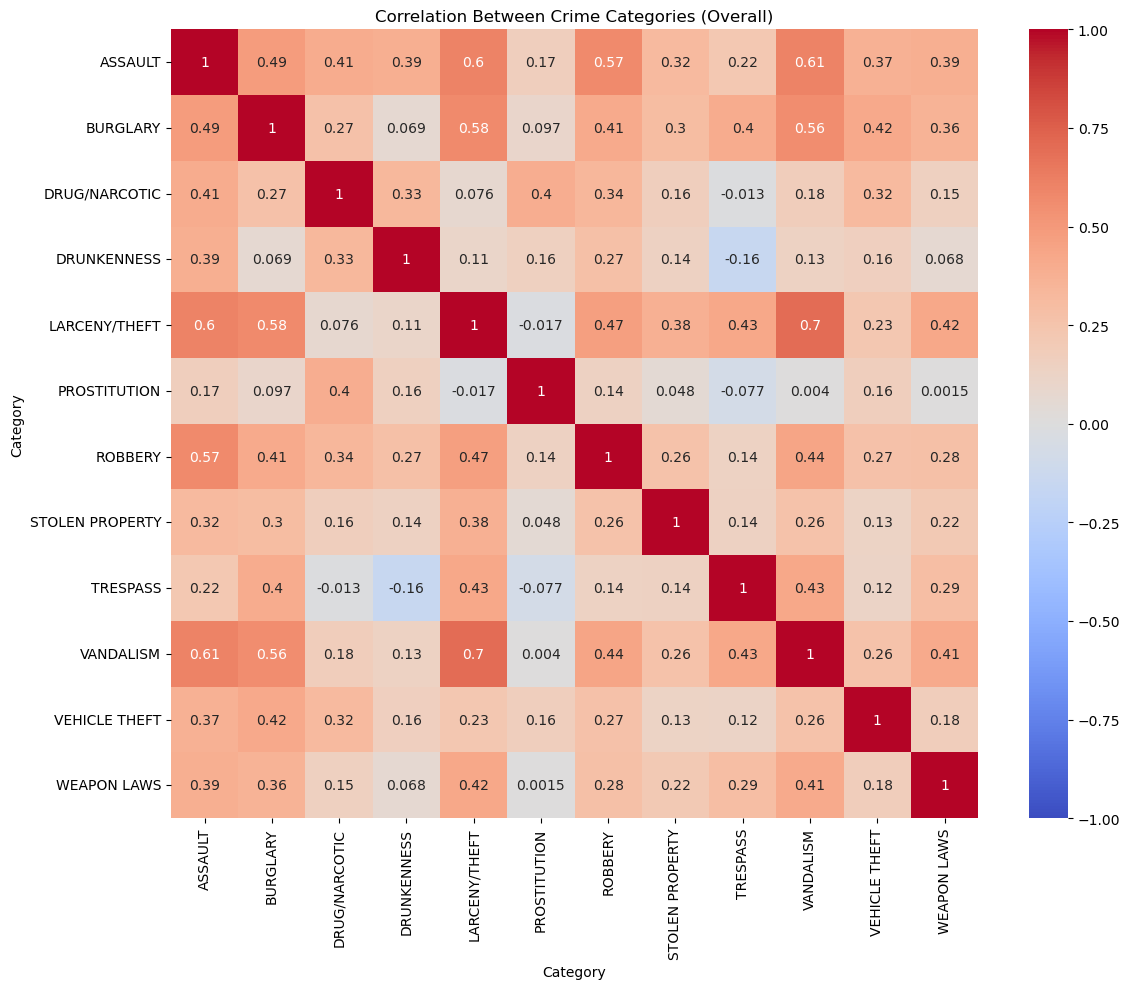

In [30]:
# Group by date and category to count occurrences
counts = data.groupby(['Date', 'Category']).size().reset_index(name='Count')

# Pivot to get categories as columns, dates as index
pivoted = counts.pivot(index='Date', columns='Category', values='Count').fillna(0)

# Compute correlation matrix between categories
corr = pivoted.corr()

# Plot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Between Crime Categories (Overall)")
plt.tight_layout()
plt.show()

In [ ]:
# Adjust layout to prevent clipping and save the figure
plt.tight_layout()
plt.savefig('../images/corr_crime_categories.png')
plt.savefig('../images/corr_crime_categories.png')

<Figure size 640x480 with 0 Axes>

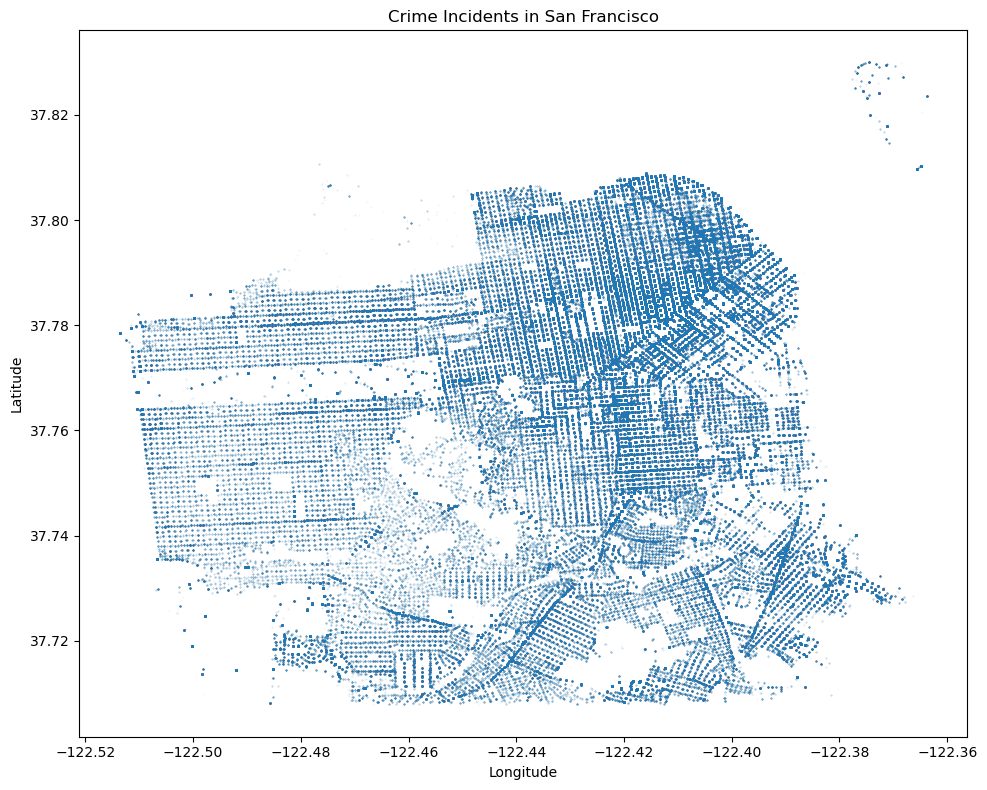

In [34]:
# create and save a simple scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(data['Longitude'], data['Latitude'], s=0.1, alpha=0.1)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Crime Incidents in San Francisco')
plt.tight_layout()
plt.savefig('../images/crime_incidents_scatter.png')
